A Convolutional Neural Network for MNIST Classification. This solution got me a score of 0.98929 on the leaderboard.

Note: this solution is loosely based on the official [tensorflow tutorial](https://www.tensorflow.org/tutorials/mnist/pros/).

## Packages and Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

## Simulation Constants ##

Download notebook and use commented out values for better performance.

In [2]:
LABELS = 10 # Number of different types of labels (1-10)
WIDTH = 28 # width / height of the image
CHANNELS = 1 # Number of colors in the image (greyscale)

VALID = 10000 # Validation data size

STEPS = 3500 #20000   # Number of steps to run
BATCH = 100 # Stochastic Gradient Descent batch size
PATCH = 5 # Convolutional Kernel size
DEPTH = 8 #32 # Convolutional Kernel depth size == Number of Convolutional Kernels
HIDDEN = 100 #1024 # Number of hidden neurons in the fully connected layer

LR = 0.001 # Learning rate

## Import Data

prepare data by 

- applying 1-hot encoding: `1 = [1,0,0...0], 2 = [0,1,0...0] ...`
- reshaping into image shape: `(# images, # vertical height, # horizontal width, # colors)`
- splitting data into train and validation set.

In [3]:
data = pd.read_csv('../input/train.csv') # Read csv file in pandas dataframe
labels = np.array(data.pop('label')) # Remove the labels as a numpy array from the dataframe
labels = LabelEncoder().fit_transform(labels)[:, None]
labels = OneHotEncoder().fit_transform(labels).todense()
data = StandardScaler().fit_transform(np.float32(data.values)) # Convert the dataframe to a numpy array
data = data.reshape(-1, WIDTH, WIDTH, CHANNELS) # Reshape the data into 42000 2d images
train_data, valid_data = data[:-VALID], data[-VALID:]
train_labels, valid_labels = labels[:-VALID], labels[-VALID:]

print('train data shape = ' + str(train_data.shape) + ' = (TRAIN, WIDTH, WIDTH, CHANNELS)')
print('labels shape = ' + str(labels.shape) + ' = (TRAIN, LABELS)')

train data shape = (32000, 28, 28, 1) = (TRAIN, WIDTH, WIDTH, CHANNELS)
labels shape = (42000, 10) = (TRAIN, LABELS)


## Model

Let's now build a network with two convolutional layers, followed by one fully connected layer. Since this is computationally pretty expensive, we'll limit the depth and number of fully connected nodes for this online notebook.

We initialize the input data with placeholders

In [4]:
tf_data = tf.placeholder(tf.float32, shape=(None, WIDTH, WIDTH, CHANNELS))
tf_labels = tf.placeholder(tf.float32, shape=(None, LABELS))

We choose a 4 layered network consisting of 2 convolutional layers with weights and biases `(w1, b1)` and `(w2,b2)`, followed by a fully connected hidden layer `(w3,b3)` with #`HIDDEN` hidden neurons and an output layer `(w4, b4)` with `10` output nodes (one-hot encoding).

We initialize the weights and biases such that the kernel has a patch size of `PATCH` and the depth of the second convolutional layer is twice the depth of the first convolutional layer `(DEPTH)`. For the rest, the fully connected hidden layer has `HIDDEN` hidden neurons.

In [5]:
w1 = tf.Variable(tf.truncated_normal([PATCH, PATCH, CHANNELS, DEPTH], stddev=0.1))
b1 = tf.Variable(tf.zeros([DEPTH]))
w2 = tf.Variable(tf.truncated_normal([PATCH, PATCH, DEPTH, 2*DEPTH], stddev=0.1))
b2 = tf.Variable(tf.constant(1.0, shape=[2*DEPTH]))
w3 = tf.Variable(tf.truncated_normal([WIDTH // 4 * WIDTH // 4 * 2*DEPTH, HIDDEN], stddev=0.1))
b3 = tf.Variable(tf.constant(1.0, shape=[HIDDEN]))
w4 = tf.Variable(tf.truncated_normal([HIDDEN, LABELS], stddev=0.1))
b4 = tf.Variable(tf.constant(1.0, shape=[LABELS]))

def logits(data):
    # Convolutional layer 1
    x = tf.nn.conv2d(data, w1, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b1)
    # Convolutional layer 2
    x = tf.nn.conv2d(x, w2, [1, 1, 1, 1], padding='SAME')
    x = tf.nn.max_pool(x, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
    x = tf.nn.relu(x + b2)
    # Fully connected layer
    x = tf.reshape(x, (-1, WIDTH // 4 * WIDTH // 4 * 2*DEPTH))
    x = tf.nn.relu(tf.matmul(x, w3) + b3)
    return tf.matmul(x, w4) + b4

# Prediction:
tf_pred = tf.nn.softmax(logits(tf_data))

We use the categorical cross entropy loss for training the model.

As optimizer we could use a Gradient Descent optimizer [with or without decaying learning rate] or one of the more sophisticated (and easier to optimize) optimizers like `Adam` or `RMSProp`

In [6]:
tf_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits(tf_data), 
                                                                 labels=tf_labels))
tf_acc = 100*tf.reduce_mean(tf.to_float(tf.equal(tf.argmax(tf_pred, 1), tf.argmax(tf_labels, 1))))

#tf_opt = tf.train.GradientDescentOptimizer(LR)
#tf_opt = tf.train.AdamOptimizer(LR)
tf_opt = tf.train.RMSPropOptimizer(LR)
tf_step = tf_opt.minimize(tf_loss)

## Train

open the session

In [7]:
init = tf.global_variables_initializer()
session = tf.Session()
session.run(init)

Run the session (Run this cell again if the desired accuracy is not yet reached).

In [8]:
ss = ShuffleSplit(n_splits=STEPS, train_size=BATCH)
ss.get_n_splits(train_data, train_labels)
history = [(0, np.nan, 10)] # Initial Error Measures
for step, (idx, _) in enumerate(ss.split(train_data,train_labels), start=1):
    fd = {tf_data:train_data[idx], tf_labels:train_labels[idx]}
    session.run(tf_step, feed_dict=fd)
    if step%500 == 0:
        fd = {tf_data:valid_data, tf_labels:valid_labels}
        valid_loss, valid_accuracy = session.run([tf_loss, tf_acc], feed_dict=fd)
        history.append((step, valid_loss, valid_accuracy))
        print('Step %i \t Valid. Acc. = %f'%(step, valid_accuracy), end='\n')

Step 500 	 Valid. Acc. = 96.620003
Step 1000 	 Valid. Acc. = 97.639999
Step 1500 	 Valid. Acc. = 97.509995
Step 2000 	 Valid. Acc. = 97.519997
Step 2500 	 Valid. Acc. = 98.369995
Step 3000 	 Valid. Acc. = 98.259995
Step 3500 	 Valid. Acc. = 98.369995


Visualize the training history:

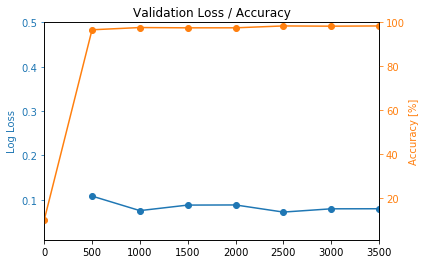

In [9]:
steps, loss, acc = zip(*history)

fig = plt.figure()
plt.title('Validation Loss / Accuracy')
ax_loss = fig.add_subplot(111)
ax_acc = ax_loss.twinx()
plt.xlabel('Training Steps')
plt.xlim(0, max(steps))

ax_loss.plot(steps, loss, '-o', color='C0')
ax_loss.set_ylabel('Log Loss', color='C0');
ax_loss.tick_params('y', colors='C0')
ax_loss.set_ylim(0.01, 0.5)

ax_acc.plot(steps, acc, '-o', color='C1')
ax_acc.set_ylabel('Accuracy [%]', color='C1');
ax_acc.tick_params('y', colors='C1')
ax_acc.set_ylim(1,100)

plt.show()

## Results

In [10]:
test = pd.read_csv('../input/test.csv') # Read csv file in pandas dataframe
test_data = StandardScaler().fit_transform(np.float32(test.values)) # Convert the dataframe to a numpy array
test_data = test_data.reshape(-1, WIDTH, WIDTH, CHANNELS) # Reshape the data into 42000 2d images

Make a prediction about the test labels

In [11]:
test_pred = session.run(tf_pred, feed_dict={tf_data:test_data})
test_labels = np.argmax(test_pred, axis=1)

Plot an example:

Label Prediction: 2


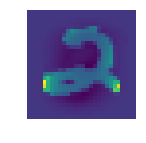

In [12]:
k = 0 # Try different image indices k
print("Label Prediction: %i"%test_labels[k])
fig = plt.figure(figsize=(2,2)); plt.axis('off')
plt.imshow(test_data[k,:,:,0]); plt.show()

## Submission

In [13]:
submission = pd.DataFrame(data={'ImageId':(np.arange(test_labels.shape[0])+1), 'Label':test_labels})
submission.to_csv('submission.csv', index=False)
submission.tail()

,ImageId,Label
27995,27996,9
27996,27997,7
27997,27998,3
27998,27999,9
27999,28000,2


## Close Session

(note: once the session is closed, the training cell cannot be run again...)

In [14]:
#session.close()